<img src='https://drive.google.com/uc?id=1mmzVvqHFc2W0nLVV42gCQbcQ2ysTnP7E'>

Working locally:
    
- modify the config.json file from notebook folder (insert the token in place of $TOKEN)

Working on Colab

- run the first two block of codes below
- create a directory called NLP_SS_day2 in your Gdrive and place the following files/folders in this directory: 
    
    * config.json file from notebook folder (and insert the token in place of $TOKEN)
    
    * util_codes from notebook folder
    
    * model folder from notebook folder

    * data folder
    
- run the third cell below

In [ ]:
## Run to connect to a gdrive
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
## check the directory folder first 
#!ls

In [ ]:
## Move to directory NLP_SS_day2
#%cd '/content/drive/MyDrive/NLP_SS_day2'


## DAY TWO: ACTIVE LEARNING

**OBJECTIVES**

The objectives of the tutorial is to:


*   Perform an active learning sampling to annotate the training data
*   Optimize your data centric strategy
*   Evaluate the performance of your model


**INPUT DATA**

1,000+ publications from EAGE publications containing the title, the abstract, the conference name and the conference location

**ACKNOWLEDGMENT**

We want to thank the EAGE for provide access of the corpus for the purpose of this course

**PARTS**

This tutorial is split into 6 parts:
1. Transfer Learning and Inital Model Training
2. Uncertainty Sampling
3. Diversity Sampling 
4. Random Sampling and Human annotation
5. Iterate the process of active learning
6. Final Model and evaluation




<img src='https://drive.google.com/uc?id=19gByT9VKCZfAOhb9fU4oZ47OCCblpT26'>

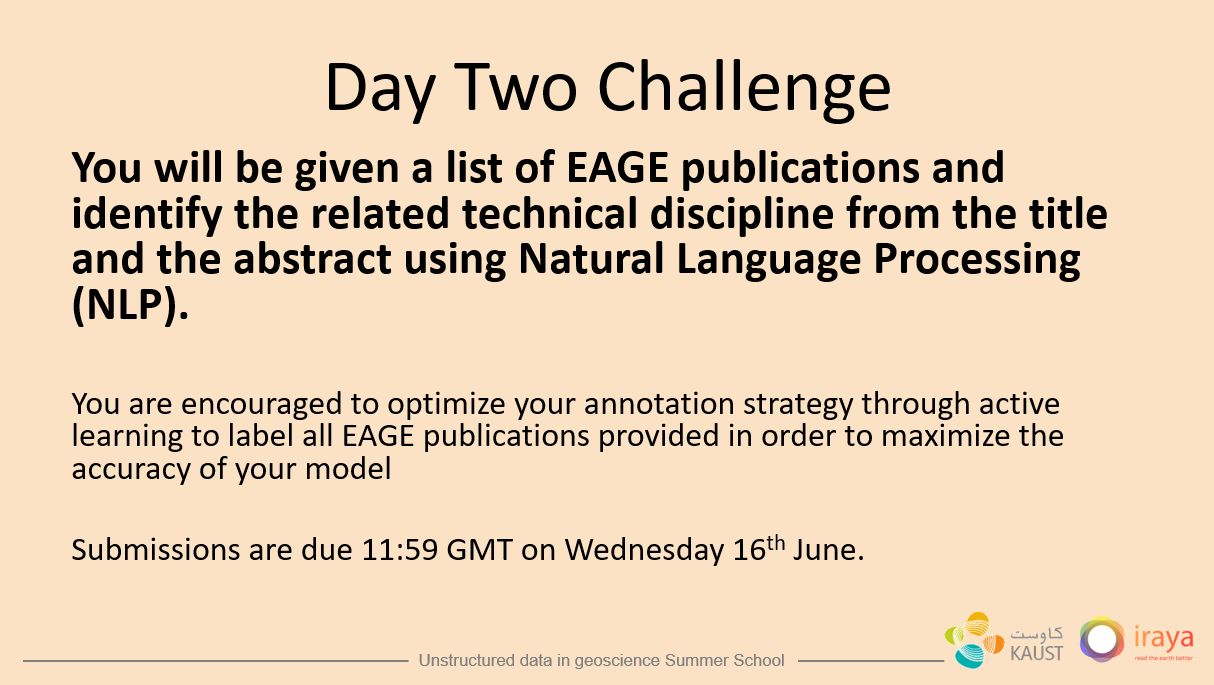
Please submit all results via https://forms.gle/8BPwBHYUVktdJD776 by 11:59pm GMT on 16 June 2021.

In [ ]:
## import packages
import sys
import os
from pathlib import Path
import json
import requests
import pickle



## import packages for data analysis
import pandas as pd
import numpy as np

# import library for plotting
import matplotlib.pyplot as plt
import seaborn as sn
colors = plt.cm.tab10(np.linspace(0, 1, 10))

# import ml library
import tensorflow.keras as keras
from sklearn.metrics import confusion_matrix

## tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer

## download stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_list = list(set(stopwords.words('english')))



## utility codes that where used in this notebook can be found in the folder `util_codes/`
module_path = str(Path.cwd() / "util_codes")
if module_path not in sys.path:
    sys.path.append(module_path)

Packages/libraries used for this tutorial are:
 - **pandas**: https://pandas.pydata.org/
 
    Great package tool for transforming dataset into easy to use data structures. This package is also widely used for data analysis which will be very helpful for this tutorial
    
    
 - **numpy**: https://numpy.org/doc/stable/

    Fundamental library for any tasks that invovles array transformation operations.
    
    
 - **tensorflow**: https://www.tensorflow.org/
    
    Contains high-level APIs that are based on Keras API for creating and developing deep learning applications. 
    
 - **sklearn**: https://scikit-learn.org/stable/getting_started.html
    
    Provides various tools for data analysis, data processing, model building and model exploration. For this tutorial we will use this library for getting the confusion matrix of our model 

 - **nltk**: https://www.nltk.org/
 
    Used to remove stopwords (ex. "the","a","an") in our text dataset.


 - **matplotlib**: https://matplotlib.org/

    Primarily used as a plotting tool for python

 - **seaborn**:  https://seaborn.pydata.org/
 
    Usually paired with matplotlib for visualizing statistical graphs.
    

# PART 1: Transfer Learning - Starting from Scratch 

In [ ]:
import data_processing #imports all the functions of `util_codes/data_procssing.py`

In this section, you are provided a NLP pretrained model that was trained on unstructured data. This is used to initiate your active learning strategy. You will then tailor this model to perform various sampling strategies.



**TASKS**
1. Create Initial dataset for model training
2. Train a model through transfer learning
3. Evaluate trained model

## 1.1 Data from Iraya's Data Atelier 
You are provided access to Iraya's Data Atelier. For this section, we would access the Data Atelier using the provided credentials and download the desired datasets.

**NOTE** 

Internet connection is needed for this part

In [ ]:
# set-up credentials
with open('config.json') as json_file:
    creds = json.load(json_file)
    
stg_instance = creds['stg_instance']
stg_token = creds['stg_token']
headers = {"Content-type": "application/json", "Authorization": f"Token {stg_token}"}

#List container for all the downloaded dataset
data_info_json = []
url_request =stg_instance+f"/data-tracker/extracted-info?page_size=100"

while url_request:
    #request access to datawarehouse
    headers = {"Content-type": "application/json", "Authorization": f"Token {stg_token}"}
    r = requests.get(url_request, headers=headers)
    response = r.json()
    
    # start the download of individual data
    for extracted_info in response['data']:
        extracted_document_info = extracted_info['attributes']
        extracted_document_info['file'] = extracted_info['relationships']['file']['data']['id']
        data_info_json.append(extracted_document_info)
    
    print(f"Downloaded {len(data_info_json)} datasets")
    
    # request for the next page
    next_url = response['links']['next']
    url_request = next_url

It is good practice to save any downloaded dataset to a json file to prevent repetition of the download process.

In [ ]:
#save to json file
os.mkdir('data')

with open('data/document_info.json', 'w') as fo:
    json.dump(data_info_json, fo)

For the purpose of this tutorial, we will only need the publication title and summaries. To help us in the annotation part, a dictionary is created where the keys are the document's doc_id and the values are the document's title and summaries.

In [ ]:
#load json file containing the downloaded dataset from datawarehouse
with open('data/document_info.json') as fp:
    nlp_data=json.load(fp)


# # Run this instead if download from datawarehouse is hindered
# with open('data/document_info_backup.json') as fp:
#     nlp_data=json.load(fp)

#convert the dataset into a dictionary
dataset_dictionary = {}
for doc_info in nlp_data:
    doc_id = doc_info['file']
    dataset_dictionary[doc_id]={'doc_abstract': doc_info['doc_text'],
                               'doc_title':doc_info['remarks']['TITLE']}

The `dataset_dictionary` contains the document's id, the title and the abstract for each document. 




In [ ]:
def get_data_info(document_id,dataset_dictionary=dataset_dictionary):
    '''
    Returns the document's title and summary
    '''
    dict_ = dataset_dictionary[document_id]
    print(f"\x1b[31mTITLE::\x1b[0m {dict_['doc_title']}")
    print(f"\x1b[31mSUMMARY:\x1b[0m {dict_['doc_abstract']}")
    

**EXAMPLE**

 get document information for document `524d3dc2-1a82-4be2-86dd-23d1c1609133`

In [ ]:
get_data_info('524d3dc2-1a82-4be2-86dd-23d1c1609133')

The dataset is transform to a csv for annotation.

In [ ]:
df_dict = pd.DataFrame(dataset_dictionary).T
df_dict.index.names = ['doc_index']
df_dict[['doc_title']].to_csv('data/unlabeled_data.csv')

## 1.2 Annotate starting labels

**TASKS**
1. Open file `data/labeled_data.csv`
2. Create a new column called `classification`
3. In the newly created table, label each document to their corresponding classification
4. The list of classification are restricted to the following **Geophysics, Geology, Geomodelling, Petrophysics and Production**


**NOTES** 
* Since this will be your initial labeled dataset, all 5 classification should exist on your csv file.
* No publications should be left unlabelled, **it may be harder as it sounds!**
* For the csv file `data/labeled_data.csv`, it was made sure by the author of the notebook to include at least 5 from each classification.


### ANNOTATION GUIDELINES
The purpose of the tutorial is to confront the student with the reality of annotations which is:


*   **HARDER** than you think 
*   **MORE CONFUSING** than you think 
*   **LESS CONSISTENT** than you think

This is perfectly fine, if you are encountering difficulities and we have drafted a number of guidelines:

1. **READ** 
    
    Carefully read the information given to you. For this tutorial you have access to the document's title and abstract. If the document's title is not enough to give you the classification, use the function `get_data_info(document_id)` to access the document's summary


2. **CHECK**
    
    Carefully check your annotations if you have the correct spelling of your labels. Make sure that your labels are among the 5 classification for this tutorial **`Geophysics, Geology, Geomodelling, Petrophysics and Production`**
   
   
3. **ASK**

    If you are still not 100% sure of your annotations, ask for a help (either with another student/friend) to identify and ensure the correctness of your annotations



**ANNOTATION EXAMPLES**

> <span style="color:green">**Easy Example**:</span> **Parameterisation of Pointbars in High-Resolution Seismic Data**
>> **Label:** Geophysics\
>> **Explanation:** Any title that has a mention of `seismic` has a high probability that the document is classified as `Geophysics`

> <span style="color:orange">**Moderately Hard Example**:</span> ***Advances in Understanding Thermally Assisted GOGD***
>> **Label:** Production\
>> **Explanation:** You cannot identify right away from the title its classification but when you read through the document's abstract you can able to recognize its main category

> <span style="color:red">**Hard Example**:</span> 
***A Summary Of The Geologists Act (2008) Of Malaysia***
>> **Label:** Production\
>> **Explanation:** Even if you check its summary, it is still hard to identify the classification of this document. We classify the document as `Production` as we set this classification as an catch-all for other classification outside of the conventional 5 classes

**Question for Students**
1. How hard or easy was it to identify the annotation of the dataset?


2. Where there any confusing labels or hard to identify titles?

3. How many times did you look up the abstract of the document?

4. Where there any conflicts in for classifying between the title and the abstract?

Once you finish to add labels to your dataset, we should be able to transfer the dataset to a dataframe. The dataframe should automatically give you the `target_pred` column, which will be `y` input of your training model

In [ ]:
#load data
# df_data = data_processing.load_data('data/labeled_data.csv')
df_data

Visualize the split of the classification to make sure we have enough representation between dataset

In [ ]:
def visualize_annotation(dataframe_data):
    #plot for bar chart
    plt.subplot(121)
    ax = dataframe_data['classification'].value_counts().plot(kind='bar',
                                        figsize=(10,3),
                                        title="Number for classification",color=colors)
    ax.set_xlabel("Classification")
    ax.set_ylabel("Frequency")

    #plot for pie chart 
    plt.subplot(122)
    dataframe_data['classification'].value_counts().plot(kind='pie',autopct = "%.2f%%",figsize=(10,3),colors=colors,ylabel='')
    plt.show()

In [ ]:
visualize_annotation(df_data)

## 1.3 Tokenization - Converting text to vectors
For any NLP application, text data inputs need to be transformed to vectors (or tensors) before being input to a model. Since this notebook is focused on model improvement through active learning, we will not go through the steps of tokenization/vectorization since it has been covered on Day 1 of this summer school.

To learn more on this step, you can check this quick explanation https://www.youtube.com/watch?v=r9QjkdSJZ2g&list=PLQY2H8rRoyvzDbLUZkbudP-MFQZwNmU4S&index=2&ab_channel=TensorFlowTensorFlowVerified

In [ ]:
# load pre-trained tokenizer used to create the initial model
with open('model/tokenizer_v2.pickle', 'rb') as handle:
    model_tokenizer = pickle.load(handle)


## pre-determined constants for converting text to vectors
max_len = 120         #maximum length of vectors
trunc_type='post'     #position where tuncation or deletion of vector if vector exceeds the alloted max_len
padding_type='post'   #position where padding or addition of vector if vector is less than the alloted max_len

We transform the text data to vectors called `features`. This `feature` column will be set as your `X` input for the trainining of your model

In [ ]:
# converts texts to vectors/feautres
df_training = data_processing.featurize(df_data,stopwords_list,model_tokenizer,max_len,trunc_type,padding_type)
df_training

## 1.4 Transfer Learning
The power of transfer learning is that it does allow you not to start from scratch. In this case we decide only to retrain the last layer of the model as a transfer learning exercise.

**TASKS**
1. Freeze provided model layers to preserve model weights
2. Unfreze/leave the last layer as trainable

In [ ]:
# load initial model - trained on a much larger dataset which application is not specified
model = keras.models.load_model('model/nlp_model_initial.h5')
model.summary()

In [ ]:
## freeze the model's layers except the last layer
for layer in model.layers:
    if layer.name == 'dense_1':
        layer.trainable=True
    else:
        layer.trainable = False
model.summary()

**NOTE**

Number of trainable parameters change when we freeze layers. This is the main concept behind transfer learning as we want to preserve the model's parameters since it was trained on a larger dataset and most likley it has captured some interesting features that you may want to preserve. 

## 1.5 Model Training

In [ ]:
def transfer_learning(h5_model, labeled_data_csv, validation_data_csv, epochs=30,
                    stopwords_list=stopwords_list,
                    model_tokenizer=model_tokenizer,
                    max_len=max_len,
                    trunc_type=trunc_type,
                    padding_type=padding_type):
    
    '''
    Train the new model to your labeled dataset 
    
    '''
    
    initial_model = keras.models.load_model(h5_model)
    
    for layer in initial_model.layers:
        if layer.name == 'dense_1':
            layer.trainable=True
        else:
            layer.trainable = False
    
    df_data = data_processing.load_data(labeled_data_csv)
    df_training = data_processing.featurize(df_data,stopwords_list,model_tokenizer,max_len,trunc_type,padding_type)
    
    df_evaluation = data_processing.load_data(validation_data_csv)
    df_evaluation = data_processing.featurize(df_evaluation,stopwords_list,model_tokenizer,max_len,trunc_type,padding_type)
    
    # data from labeled data
    X_train = np.vstack(df_training['features'])
    y_train = np.vstack(df_training['target_pred'])

    #data from evaluation data
    X_val = np.vstack(df_evaluation['features'])
    y_val = np.vstack(df_evaluation['target_pred'])
    
    
    
    history=initial_model.fit(X_train,y_train,epochs=epochs,validation_data=(X_val,y_val))
    
    #visualize model's loss and accuracy
    figure = plt.figure(figsize=(20,6))
    plt.subplot(121)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy', fontsize=18)
    plt.ylabel('accuracy', fontsize=14)
    plt.xlabel('epoch', fontsize=14)
    plt.legend(['train', 'validation'], loc='lower right')

    plt.subplot(122)
    predictions = initial_model.predict(X_val)

    #Compute for the confusion matrix
    matrix = confusion_matrix(predictions.argmax(axis=1),y_val.argmax(axis=1))
    columns = ['Geophysics','Petrophysics','Geology','Geomodelling','Production']
    df_cm = pd.DataFrame(matrix,index=columns,columns=columns)
    ax = sn.heatmap(df_cm, cmap='Oranges', annot=True)
    plt.title('Confusion Matrix', fontsize=18)
    plt.xlabel('Ground Truth', fontsize=14)
    plt.ylabel('Predictions', fontsize=14)

    return initial_model,history,matrix,figure 

In [ ]:
new_model,model_history,conf_matrix,charts = transfer_learning('model/nlp_model_initial.h5', 'data/labeled_data.csv', 'data/evaluation_data.csv',20)

**Note**: As we move on to the next part of the notebook we should expect an increase on the `val_accuracy` of the model

In [ ]:
#visualize the progress of loss and accuracy of the model's training and also the confusion matrix of your validation dataset
charts

Using the confusion matrix you can able to idenify each classification accuracy.

In [ ]:
# value of your confusion matrix
conf_matrix

# PART 2: Uncertainty Sampling - Model's Low Confidence



**TASKS**
1. Run Uncertainty Sampling
2. Sample data with low probability confidence

<img src='https://drive.google.com/uc?id=1biGRUKd8tjAU21kMN5eNBNI1Oa-GO1Ag'>

## 2.1 Load unlabeled dataset

At this point of the tutorial, we will now use the downloaded dataset from Iraya's Data Atelier. This dataset will be considered as our unlabeled data. 

Like our labeled data, the unlabeled data is composed of text data. So before we can use our unlabeled data we need to convert first the texts data to vectors.

In [ ]:
# load your unlabeled dataset and convert them to vector data
df_unlabeled = data_processing.load_data('data/unlabeled_data.csv')
df_unlabeled = data_processing.featurize(df_unlabeled,stopwords_list,model_tokenizer,max_len,trunc_type,padding_type) #convert your texts to vectors
df_unlabeled

To make sure that we remove duplication in our dataset, we will need additional process to remove the already labeled and validation samples in our existing  data.

In [ ]:
def remove_labeled_data(unlabeled_dataframe,labeled_data_csv, validation_data_csv):
    '''
    Removes your labeled and validation data from your unlabeld data
    '''

    # Load your labeled and validation data
    label_dataframe = data_processing.load_data(labeled_data_csv)
    evaluation_dataframe = data_processing.load_data(validation_data_csv)
    
    # Create mask from the loaded labeled and validation list and remove them 
    # in your unlabeled data
    mask_list =  label_dataframe['doc_index'].tolist() + evaluation_dataframe['doc_index'].tolist()
    mask = unlabeled_dataframe['doc_index'].isin(mask_list)
    unlabeled_dataframe_cleaned = unlabeled_dataframe[~mask]

    return unlabeled_dataframe_cleaned 

**## Check labeled and evaluation for conflict**

In [ ]:

df_unlabeled = remove_labeled_data(df_unlabeled,'data/labeled_data.csv', 'data/evaluation_data.csv')
df_unlabeled

At this point you now have a dataset in a structured dataframe that we can use for active learning.

## 2.2 Uncertainty Sampling
The first step of active learning is focusing on the uncertainity sampling.

Run the code below to execute the uncertainty sampling of the dataset. To learn more of the implementation below, you can check the code base inside the file `util_codes/uncertainty_sampling.py`


In [ ]:
import uncertainty_sampling #imports all the functions of `util_codes/uncertatinty_sampling.py`


**NOTE**

 The code below may take a while to execute as it try to predict and get the probability confidence of each samples in your unlabeled data

In [ ]:
df_uncertain = uncertainty_sampling.uncertainty_samples(df_unlabeled,model,uncertainty_sampling.least_confidence)
df_uncertain

The uncertainty sampling will give each samples an uncertainty score that ranges from 0-1. The closer the sample's score to 1 the higher its uncertainty and the lower its confidence, based on the least confidence definition.

From the uncertainty score, we can now identify the samples with low probability confidence. 
This should be interpretated as **samples where the model is currently confused**.



In [ ]:
filtered_uncertainty = 0.1 #choose a number from 0-1, we want to filter out samples that has greater than the choosen 
                           #uncertainty

low_confidence_samples = df_uncertain[df_uncertain['uncertainty'] >= filtered_uncertainty]
low_confidence_samples

**NOTES**

The value of 0.1 or 10% is a good starting point. This should not be seen as a 
static value and will likely vary while you are implementing your active learning strategy

In addition further implementation can consider other confidence computations such as the margin of confidence, ratio of confidence or the entropy


# PART 3: Diversity Sampling - Clustered Selection


**TASKS**:
1. Run Diversity Sampling
2. Sample each cluster's centroid, outlier and member


<img src='https://drive.google.com/uc?id=1rMC_DM1pMGXECdw_U_QypBD73mCUM3Mh'>

## 3.1 Diversity Sampling
With the chosen samples from uncertainty sampling, we do a clustering between these dataset and identify each cluster's centroids,outliers and members. The reason in doing this is to have a good representation for each cluster and not to oversample only to a specific cluster.



In [ ]:
import diversity_sampling #imports all the functions of `util_codes/diversity_sampling.py`

To learn more on the implementation for diversity sampling, you can open the pyhon file `util_codes/diversity_sampling` and check the functions used in this tutorial.

In [ ]:
# convert dataframe to list for diversity sampling
sample_list = low_confidence_samples.values.tolist()

# do a diversity sampling to the low confidence samples
diversity = diversity_sampling.get_cluster_samples(sample_list)
diversity_df = pd.DataFrame(diversity)
diversity_df.columns = ['doc_index','features','cluster_class']
diversity_df

**NOTES**

The diversity sampling is using a K-Means implementation with a cosine distance computation. 

Do note that diversity and uncertainity samplings have multiple ways of being combined separtely and in tandem. They should be seen first for what they are building blocks (**Legos**) for your active learning strategy.

Uncertainty and diversity samplings are often bais onwards a certain kind of data, useful data but still a certain kind. Therefore it is good practice to compensate/evaluate such a sampling with some random sampling.

# PART 4: Random Sampling - Stochastic Selection
The random sampling has 2 powers:


*   It is easy to implement 
*   It is the closest to the truth 

it has 1 weakness:


*   It is not efficent (**you may end up to label all your data!**)


**TASKS**
1. Run Random Sampling
2. Annotate/label the exported samples

<img src='https://drive.google.com/uc?id=1lEQXAQJuj8BqYgjHfThRzRglMB0Bhrco'>

## 4.1 Random Sampling
Random sampling is the easiest way of picking a sample from a dataset. On this section we will pick a sample randomly to be chosen for annotation.


In [ ]:
def Random_sampling(unlabeled_dataframe,diversity_dataframe,n_samples):
    '''
    Pick randomly from the unlabeled data and making sure that the picked data
    is not part of the diversity samples
    '''
    diversity_samples = diversity_dataframe['doc_index'].tolist()
    mask = unlabeled_dataframe['doc_index'].isin(diversity_samples)
    unused_samples = unlabeled_dataframe[~mask]
    random_samples = unused_samples.sample(n=n_samples)
    return random_samples

In [ ]:
random_df = Random_sampling(df_unlabeled,diversity_df,10)
random_df

## 4.2 Export the samples to a csv file
For easier annotation of the selected samples, we will need to export the samples to a csv file. 

In [ ]:
doc_index_list = diversity_df['doc_index'].tolist()  + random_df['doc_index'].tolist()
doc_to_annotate={}
for doc_index in doc_index_list:
    doc_to_annotate[doc_index] = dataset_dictionary[doc_index]
    
annotate_df = pd.DataFrame(doc_to_annotate).T[['doc_title']]
annotate_df.to_csv('data/TO_LABEL_CYCLE1.csv')


## 4.3 Human Annotation
**TASKS**
1. Like the annotation we did from the beginning, open the file `data/TO_LABEL_CYCLE1.csv` and label each document accordingly
2. Once done, transfer all the data in the csv file to `data/labeled_data_CYCLE1.csv`. This includes the data from `data/labeled_data.csv`

**REPEAT THE TASKS TO COPY FOR THE OTHER CYCLES BY ONLY CHANGING THE NUMBER IN THE FILE NAME**

Example:

TO_LABEL_CYCLE1.csv->TO_LABEL_CYCLE2.csv

labeled_data_CYCLE1.csv->labeled_data_CYCLE2.csv

**Notes**:
* Do not replace any dataset in `data/labeled_data.csv`. Just append or paste the additional dataset from `data/TO_LABEL_CYCLE1.csv`
* Make sure to only use the five classifications: **`Geophysics, Geology, Geomodelling, Petrophysics and Production`**
* You can use the function below to display the document summary.
```python
get_data_info(document_id)
```

After annotation, you can evaluate the distribution of your annotation by executing the code below.

In [ ]:
#visualize annotated dataset to see your progress
df_data = data_processing.load_data('data/labeled_data_CYCLE1.csv')
visualize_annotation(df_data)

**YOU HAVE NOW LABELLED 50+ UNCERTAINTY+DIVERSITY(14)+ RANDOM SAMPLES (10)** (the numbers are indicative only since it is depended of the labels selected)

# PART 5: Iterate

<img src='https://drive.google.com/uc?id=12wZHwPTTHmorIGIVxp87g2_pRJ51Co-B'>

In this section we iterate our workflow to further improve our model's accuracy

## 5.1 Second Iteration

With your added training data, you can now further improve your model.

In [ ]:
new_model,model_history,conf_matrix,charts = transfer_learning('model/nlp_model_initial.h5', 'data/labeled_data_CYCLE1.csv', 'data/evaluation_data.csv',20)

Visualize the progress of your model

In [ ]:
charts

At this stage, we will automate the process of active learning. The function provided below will automatically do the uncertainty,diversity and random sampling of the dataset for you. 

In [ ]:
def active_learning(unlabeled_data,model,filtered_uncertainty,dataset_dictionary,output_csv):
    """
    Compiled the workflow done in parts 2-4
    """

    df_uncertain = uncertainty_sampling.uncertainty_samples(df_unlabeled,model,uncertainty_sampling.least_confidence)
    low_confidence_samples = df_uncertain[df_uncertain['uncertainty'] >= filtered_uncertainty]
    low_confidence_samples['diversity'] = ''
    sample_list = low_confidence_samples.values.tolist()
    diversity = diversity_sampling.get_cluster_samples(sample_list)
    diversity_df = pd.DataFrame(diversity)
    diversity_df.columns = ['doc_index','features','cluster_class','cluster_score']
    
    random_df = Random_sampling(unlabeled_data,diversity_df,10)
    
    doc_index_list = diversity_df['doc_index'].tolist() + random_df['doc_index'].tolist()
    doc_to_annotate={}
    for doc_index in doc_index_list:
        doc_to_annotate[doc_index] = dataset_dictionary[doc_index]

    annotate_df = pd.DataFrame(doc_to_annotate).T[['doc_title']]
    annotate_df.to_csv(output_csv)

In [ ]:
# remove labeled data from the unlabeled samples
df_unlabeled = remove_labeled_data(df_unlabeled,'data/labeled_data_CYCLE1.csv', 'data/evaluation_data.csv')
df_unlabeled

In [ ]:
#perform uncertainty and diversity automatically
active_learning(df_unlabeled,new_model,0.1,dataset_dictionary,'data/TO_LABEL_CYCLE2.csv')

**TASKS**
1. Perform another human annotation on `data/TO_LABEL_CYCLE2.csv`
2. Transfer the new annotations to `data/labeled_data_CYCLE2.csv` and add your labeled data from previous cycles 

## 4.2 Third Iteration (Optional)
At this point since you have grasp the concept of active learning, the third iteration of your active learning is optional. If you want to improve your model and adding more dataset to your training, you are welcome to run the next steps.

In [ ]:
new_model,model_history,conf_matrix,charts = transfer_learning('model/nlp_model_initial.h5', 'data/labeled_data_CYCLE2.csv', 'data/evaluation_data.csv',20)

In [ ]:
# Visualize the progress of your model
charts

In [ ]:
# remove labeled data from the unlabeled samples
df_unlabeled = remove_labeled_data(df_unlabeled,'data/labeled_data_CYCLE2.csv', 'data/evaluation_data.csv')
df_unlabeled

In [ ]:
#perform uncertainty and diversity automatically
active_learning(df_unlabeled,new_model,0.1,dataset_dictionary,'data/TO_LABEL_CYCLE3.csv')

**OPTIONAL TASKS**
1. Perform another human annotation on `data/TO_LABEL_CYCLE3.csv`
2. Transfer the new annotations to `data/labeled_data_CYCLE3.csv` and add your labeled data from previous cycles 

## PART 5: Final model and evaluation
Finally we want to evaluate your final model's prediction. 

## 5.1 Final Model Training


In [ ]:
# load your final annotations
Final_labeled_csv = 'data/labeled_data_CYCLE3.csv'

#visualize annotated dataset to see your progress
df_data = data_processing.load_data(Final_labeled_csv)
print(f'Total number of labels: {len(df_data)}')
visualize_annotation(df_data)

In [ ]:
new_model,model_history,conf_matrix,charts = transfer_learning('model/nlp_model_initial.h5', Final_labeled_csv, 'data/evaluation_data.csv',10)

In [ ]:
# Visualize your model's training and its confusion matrix for the evaluation data
charts

## 5.2 Predictions

In [ ]:
df_final_pred = data_processing.load_data('data/unlabeled_data.csv')
df_final_pred = data_processing.featurize(df_final_pred,stopwords_list,model_tokenizer,max_len,trunc_type,padding_type)
X_test = np.vstack(df_final_pred['features'])
predictions = new_model.predict(X_test)
df_final_pred['predictions'] = predictions.argmax(axis=-1)

In [ ]:
df_final_pred.to_csv('data/final_predictions.csv')

## FINAL TASK
Submit your **`final_predictions.csv`** to the google form provided for submissions. We will evaluate your final predictions and compare it to the work of other students.



## GO BEYOND

If like me, you find the subject of active learning facinating and not teached enough in traditional ML courses, you may want to explore further the domain by:


1.   Testing active learning not only on the titles but also by including abstracts both in tandem or separetly
2.   Testing other clustering techniques such as T-SNE 
3.   Combining uncertainity, diversity and random sampling in new innovative ways, no-one as thought off
4.   Unfreeze more layers of the NN

And publish on Active Learning!



# **Data disclaimer: Limitations on Use of Test Data**

 The sample test data used for this experiment is extracted from ED2K, an initiative between Iraya Energies and European Association of Geoscientists and Engineer (EAGE) to process the EarthDoc database, using the latest in machine learning techniques to read the earth better.

The API access will be available until 17th June 2021 and is available for academic use only. Thank you in advance for deletion of downloaded dataset after the completion of the class. For the utilization of data beyond the duration of this Summer School or use of bigger ED2K dataset, pls send an email request to info@irayaenergies.com.

The Jupyter notebook used in this session may be available for use beyond this class using your own dataset, thank you in advance for the citation of Iraya Energies. 